In [ ]:
# Copyright 2020 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/templates/ai_platform_notebooks_template_hybrid.ipynb"">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/templates/ai_platform_notebooks_template_hybrid.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## Overview

### Objective

Estimate how much an existing customer will spend in the future based on their historical orders to find similar new customers using lookalike features of advertising tools.

In this tutorial, you will:
- Define how far in the future you want to predict the monetary value of your customers (ex: 3 months)
- Use a moving session concept to aggregate multiple inputs and targets per customer (For more details, see the *Create inputs and targets* section of this tutorial).
- Use primarly inputs such as Recency, Frequency and Monetary which are common values to use in an LTV context, especially in statistical model due to their distribution patterns.
- Accelerate model development by using AutoML from within BigQuery ML.
- Predict the monetary value of all existing customers for a predefined period of time in the future.
- Use first-party data to extract the most valuable customers email in order to run lookalike campaigns using the [Google Ads API][ads_api]. You can extend the concept to do the same using [Facebook API][fb_api].

[ads_api]:https://developers.google.com/adwords/api/docs/samples/python/remarketing#create-and-populate-a-user-list
[fb_api]:https://www.facebook.com/business/help/341425252616329?id=2469097953376494



### Sales dataset
Sales data can be of different forms but generally look like a list of transactions where each record contains at a minimum the following:
- a customer reference
- a transaction date
- a transaction reference
- a monetary value

Each record usually represents one of the following:
- An entire order which contains aggregated values across products for that order. You can find the total order value in the record.
- A part of a transaction which contains a unique product, some of its characteristics including SKU and unit price and the quantity ordered. 

This tutorial uses the latter.

You can run this tutorial with your own dataset. The dataset that you provide must meet the following requirements:
1. Each row represents a transaction related to a product item and linked to a transaction, a date and a customer. A row can be either a transaction (quantity is > 0) or a return (quantity is < 0)
1. Columns must include the following:

| Field name | Type | Description |
| :-|:-|:-|
| customer_id | STRING | First party identifier of the customer.	 |
| order_id | STRING | First party identitfier of the order. |
| order_date | DATE | Date of the order.  |
| product_sku | STRING | First party identitifer of the product. |
| qty | INTEGER | Quantity of the product either ordered or returned. |
| unit_price | FLOAT | Unit price of the product. |

### Customer dataset
Customer data often resides in a Customer Relationship Management (CRM). 

This first party data is key for companies that want to provide a certain level of customer service.

This tutorial only uses two columns of the customer dataset:
- customer_id to join with the sales data
- email to create a marketing list.

The public dataset contains other fields that are not relevant for this tutorial and your data might have other fields. This tutorial focuses on an activation based on email addresses.

### Costs 

This tutorial uses billable components of Google Cloud Platform (GCP):

* BigQuery
* BigQuery ML
* Cloud Storage

To learn more about pricing:
- Read [BigQuery pricing](https://cloud.google.com/bigquery/docs/pricing)
- Read [BigQuery ML pricing](https://cloud.google.com/bigquery-ml/pricing)
- Read [Cloud Storage pricing](https://cloud.google.com/storage/pricing)
- Use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

### Terminology
- **'Input' transactions**: The set of transactions that the training task uses to create inputs values for the model.
- **'Target' transactions**: The set of transactions that the training task uses to create the target value to predict. The target value is an aggregated monetary value per customer for a defined timeline.
- **Threshold date**: Date that separates 'Input' transactions from 'Target' transactions per customer.

## Setup
This step sets up packages, variables, authentication, APIs clients and resources for Google Cloud and Adwords.

### Install packages and dependencies
Installs libraries, packages and dependencies to run this tutorial

In [1]:
# Install libraries. 
# The magic cells insures that those libraries can be part of a custom container
# if moving the code somewhere else.
%pip install -q googleads
%pip install -q -U kfp matplotlib Faker --user

# Automatically restart kernel after installs
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)  

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 276kB 14.1MB/s 
     |████████████████████████████████| 102kB 8.7MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 122kB 4.7MB/s 
     |████████████████████████████████| 11.6MB 39.6MB/s 
     |████████████████████████████████| 1.0MB 45.3MB/s 
     |████████████████████████████████| 1.5MB 48.8MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 61kB 6.4MB/s 
     |████████████████████████████████| 204kB 45.9MB/s 
ERROR: nbclient 0.5.0 has requirement jupyter-client>=6.1.5, but you'll have jupyter-client 5.3.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-

### Import packages

In [2]:
# Import
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, json, random
import hashlib, uuid
import time, calendar, math
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from datetime import datetime
from google.cloud import bigquery

from googleads import adwords

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Set up your GCP project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. If you are running this notebook locally, you will need to install [Google Cloud SDK](https://cloud.google.com/sdk).

5. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

In [3]:
PROJECT_ID = "[YOUR-PROJECT]" #@param {type:"string"}
REGION = "US"
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Authenticate your GCP account
If you are using AI Platform Notebooks, you are already authenticated so there is no need to run this step.

In [4]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

### Create a working dataset
This tutorial mostly uses BigQuery magic cells where the --params field does not support variables for datasets, tables and column names. 

This steps hardcode the dataset where all the steps of this tutorial happens.

In [ ]:
! bq show $PROJECT_ID:ltv_ecommerce || bq mk $PROJECT_ID:ltv_ecommerce


### Load example tables

In [ ]:
# Loads CRM data
!bq load \
  --project_id $PROJECT_ID \
  --skip_leading_rows 1 \
  --max_bad_records 100000 \
  --replace \
  --field_delimiter "," \
  --autodetect \
  ltv_ecommerce.00_crm \
  gs://solutions-public-assets/analytics-componentized-patterns/ltv/crm.csv

In [ ]:
# Loads Sales data
!bq load \
  --project_id $PROJECT_ID \
  --skip_leading_rows 1 \
  --max_bad_records 100000 \
  --replace \
  --field_delimiter "," \
  --autodetect \
  ltv_ecommerce.10_orders \
  gs://solutions-public-assets/analytics-componentized-patterns/ltv/sales_*

### Create clients

In [ ]:
# BigQuery client
bq_client = bigquery.Client(project=PROJECT_ID)

## [Optional] Match your dataset to template
If you use the example data, you can skip this step.

This tutorial assumes that you have a dump of your sales data already available in BigQuery located at `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]`

You are free to adapt the SQL query in the next cell to a SQL statement that transforms your data according to the template.

In [ ]:
%%bigquery --params $MATCH_FIELDS --project $PROJECT_ID

CREATE OR REPLACE TABLE `ltv_ecommerce.10_orders` AS (
SELECT
  CAST(customer_id AS STRING)  AS customer_id,
  order_id  AS order_id,
  transaction_date AS transaction_date,
  product_sku AS product_sku,
  qty AS qty,
  unit_price AS unit_price
FROM
  `[YOUR_PROJECT].[YOUR_DATASET].[YOUR_SOURCE_TABLE]`
);

""


## Analyze dataset

**Some charts might use a log scale.**



#### Quantity
This sections shows how to use the BigQuery [ML BUCKETIZE][bucketize] preprocessing function to create buckets of data for quantity and display a log scaled distribution of the `qty` field.

[bucketize]:https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-preprocessing-functions#bucketize

In [ ]:
%%bigquery df_histo_qty --project $PROJECT_ID

WITH
  min_max AS (
  SELECT
    MIN(qty) min_qty,
    MAX(qty) max_qty,
    CEIL((MAX(qty) - MIN(qty)) / 100) step
  FROM
    `ltv_ecommerce.10_orders` 
)
SELECT
  COUNT(1) c,
  bucket_same_size AS bucket
FROM (
  SELECT
    -- Creates (1000-100)/100 + 1 buckets of data.
    ML.BUCKETIZE(qty, GENERATE_ARRAY(min_qty, max_qty, step)) AS bucket_same_size,
    -- Creates custom ranges.
    ML.BUCKETIZE(qty, [-1, -1, -2, -3, -4, -5, 0, 1, 2, 3, 4, 5]) AS bucket_specific,
  FROM
    `ltv_ecommerce.10_orders`, min_max )
  # WHERE bucket != "bin_1" and bucket != "bin_2"
GROUP BY
  bucket
  -- Ohterwise, orders bin_10 before bin_2
ORDER BY CAST(SPLIT(bucket, "_")[OFFSET(1)] AS INT64)

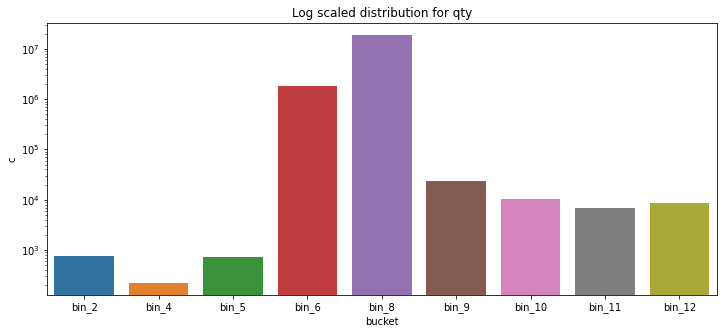

In [ ]:
# Uses a log scale for bucket_same_size.
# Can remove the log scale when using bucket_specific.
plt.figure(figsize=(12,5))
plt.title('Log scaled distribution for qty')
hqty = sns.barplot( x='bucket', y='c', data=df_histo_qty)
hqty.set_yscale("log")


#### Unit price

In [ ]:
%%bigquery df_histo_unit_price --project $PROJECT_ID

WITH
  min_max AS (
  SELECT
    MIN(unit_price) min_unit_price,
    MAX(unit_price) max_unit_price,
    CEIL((MAX(unit_price) - MIN(unit_price)) / 10) step
  FROM
    `ltv_ecommerce.10_orders` 
)

SELECT
  COUNT(1) c,
  bucket_same_size AS bucket
FROM (
  SELECT
    -- Creates (1000-100)/100 + 1 buckets of data.
    ML.BUCKETIZE(unit_price, GENERATE_ARRAY(min_unit_price, max_unit_price, step)) AS bucket_same_size,
    -- Creates custom ranges.
    ML.BUCKETIZE(unit_price, [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000]) AS bucket_specific,
  FROM
    `ltv_ecommerce.10_orders`, min_max )
  # WHERE bucket != "bin_1" and bucket != "bin_2"
GROUP BY
  bucket
  -- Ohterwise, orders bin_10 before bin_2
ORDER BY CAST(SPLIT(bucket, "_")[OFFSET(1)] AS INT64)

Text(0.5, 1.0, 'Log scaled distribution for unit_price')

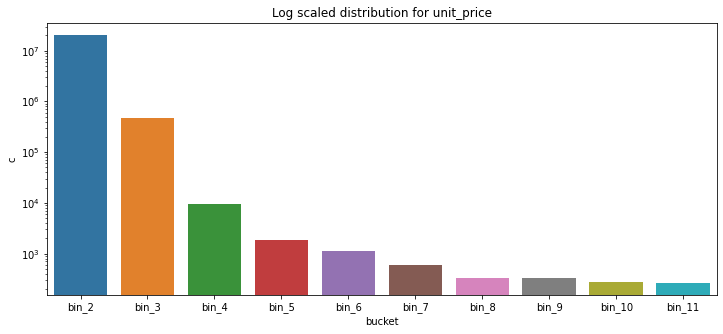

In [ ]:
# Uses a log scale for bucket_same_size.
# Can remove the log scale when using bucket_specific.
plt.figure(figsize=(12,5))
q = sns.barplot( x='bucket', y='c', data=df_histo_unit_price)
q.set_yscale("log")
plt.title('Log scaled distribution for unit_price')

## Set parameters for LTV
Some parameters useful to run some of the queries in this tutorial:

1. **WINDOW_STEP**: How many days between threshold dates.
1. **WINDOW_STEP_INITIAL**: How many days between the first order and the first threshold date. A threshold date is when BigQuery computes inputs and targets.
1. **WINDOW_LENGTH**: How many days back to use for input transactions. The default value is 0 which means that this tutorial takes all transactions before the threshold date.
1. **LENGTH_FUTURE**: How far in the future to predict the monetary value. At every threshold date, BigQuery calculate the target value for all orders that happen LENGTH_FUTURE after the threshold date.
1. **MAX_STDV_MONETARY**: Standard deviation of the monetary value per customer. Removes orders per customer that have order values with a greater standard deviation.
1. **MAX_STDV_QTY**: Standard deviation of the quantity of products per customer. Removes orders per customer that have product quantity with a greater standard deviation.
1. **TOP_LTV_RATIO**: Percentage of top customers that you want to keep for your lookalike activation.

You can change those parameters to see how they impact the model especially the parameters related to the window. There is no obvious rule to set values as they depend on how data looks.

For example:
- If your customers buy multiple times a week, you could try to predict monetary value on a weekly basis.
- If you have a lot of data, you can create more windows by decreasing their sizes and possibly the number of days between threshold dates.

After multiple trials, this tutorial chose values that provides a decent result for the example dataset.

In [5]:
LTV_PARAMS = {
    'WINDOW_LENGTH': 0,
    'WINDOW_STEP': 30,
    'WINDOW_STEP_INITIAL': 90,
    'LENGTH_FUTURE': 30,
    'MAX_STDV_MONETARY': 500,
    'MAX_STDV_QTY': 100, 
    'TOP_LTV_RATIO': 0.2
}
LTV_PARAMS

{'LENGTH_FUTURE': 30,
 'MAX_STDV_MONETARY': 500,
 'MAX_STDV_QTY': 100,
 'TOP_LTV_RATIO': 0.2,
 'WINDOW_LENGTH': 0,
 'WINDOW_STEP': 30,
 'WINDOW_STEP_INITIAL': 90}

## Aggregate per day per customer
This query aggregates all orders per day per customer. This is useful if:
- Your database has multiple records for one order, for example if each record represent a product in a transaction, which is the case in this tutorial.
- Customers bought multiple times during one day. This guide is based on LTV per day so no need to keep hourly records (unless you decided to use that data as a feature).

This query also
1. Creates inputs related to returns.
1. Removes orders with outliers per customer. This means that high spending customers remain in the dataset but orders that seems unusual for a unique customers are filtered out.

In [ ]:
%%bigquery --params $LTV_PARAMS --project $PROJECT_ID

DECLARE MAX_STDV_MONETARY INT64 DEFAULT @MAX_STDV_MONETARY;
DECLARE MAX_STDV_QTY INT64 DEFAULT @MAX_STDV_QTY;

CREATE OR REPLACE TABLE `ltv_ecommerce.20_aggred` AS
SELECT
  customer_id,
  order_day,
  ROUND(day_value_after_returns, 2) AS value,
  day_qty_after_returns as qty_articles,
  day_num_returns AS num_returns,
  CEIL(avg_time_to_return) AS time_to_return
FROM (
  SELECT
    customer_id,
    order_day,
    SUM(order_value_after_returns) AS day_value_after_returns,
    STDDEV(SUM(order_value_after_returns)) OVER(PARTITION BY customer_id ORDER BY SUM(order_value_after_returns)) AS stdv_value,
    SUM(order_qty_after_returns) AS day_qty_after_returns,
    STDDEV(SUM(order_qty_after_returns)) OVER(PARTITION BY customer_id ORDER BY SUM(order_qty_after_returns)) AS stdv_qty,
    CASE
      WHEN MIN(order_min_qty) < 0 THEN count(1)
      ELSE 0
    END AS day_num_returns,
    CASE
      WHEN MIN(order_min_qty) < 0 THEN AVG(time_to_return)
      ELSE NULL
    END AS avg_time_to_return
  FROM (
    SELECT 
      customer_id,
      order_id,
      -- Gives the order date vs return(s) dates.
      MIN(transaction_date) AS order_day,
      MAX(transaction_date) AS return_final_day,
      DATE_DIFF(MAX(transaction_date), MIN(transaction_date), DAY) AS time_to_return,
      -- Aggregates all products in the order 
      -- and all products returned later.
      SUM(qty * unit_price) AS order_value_after_returns,
      SUM(qty) AS order_qty_after_returns,
      -- If negative, order has qty return(s).
      MIN(qty) order_min_qty
    FROM 
      `ltv_ecommerce.10_orders`
    GROUP BY
      customer_id,
      order_id)
  GROUP BY
    customer_id,
    order_day)
WHERE
  -- [Optional] Remove dates with outliers per a customer.
  (stdv_value < MAX_STDV_MONETARY
    OR stdv_value IS NULL) AND
  (stdv_qty < MAX_STDV_QTY
    OR stdv_qty IS NULL);


SELECT * FROM `ltv_ecommerce.20_aggred` LIMIT 5;

,customer_id,order_day,value,qty_articles,num_returns,time_to_return
0,8,2017-03-15,141.88,12,0,NaN
1,11,2017-03-22,914.77,25,24,2.0
2,22,2017-01-10,46.98,2,0,NaN
3,26,2017-02-16,374.92,8,12,3.0
4,34,2017-05-13,651.70,32,34,3.0


## Check distributions
This tutorial does minimum data cleansing and focuses mostly on transforming a list of transactions into workable inputs for the model.

This section checks that data is generally usable.

### Per date

In [ ]:
%%bigquery df_dist_dates --project $PROJECT_ID

SELECT count(1) c, SUBSTR(CAST(order_day AS STRING), 0, 7) as yyyy_mm
FROM `ltv_ecommerce.20_aggred`
WHERE qty_articles > 0
GROUP BY yyyy_mm 
ORDER BY yyyy_mm

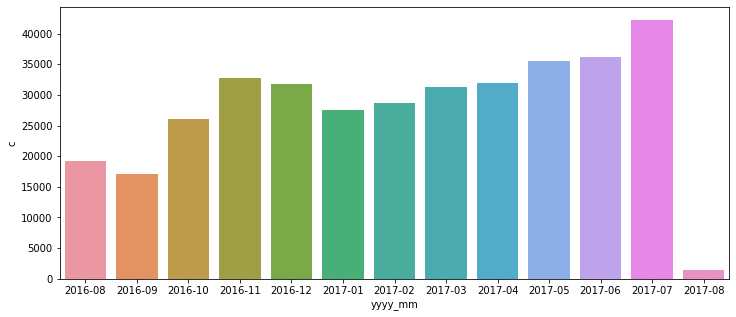

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot( x='yyyy_mm', y='c', data=df_dist_dates)

Orders are quite well distributed across the year despite a lower number in the early days of the dataset. You can keep this in mind when choosing a value for `WINDOW_STEP_INITIAL`.

### Per customer

In [ ]:
%%bigquery df_dist_customers --params $LTV_PARAMS --project $PROJECT_ID

SELECT customer_id, count(1) c
FROM `ltv_ecommerce.20_aggred`
GROUP BY customer_id

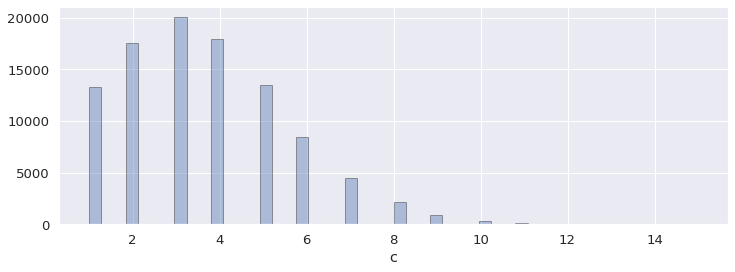

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_dist_customers['c'], hist_kws=dict(ec="k"), kde=False)

The number of transactions per customer is distributed across a few discrete values with no clear outliers.

### Per quantity
This section looks at the general distribution of the number of articles per orders and check if there are some outliers.

In [ ]:
%%bigquery df_dist_qty --params $LTV_PARAMS --project $PROJECT_ID

SELECT qty_articles, count(1) c
FROM `ltv_ecommerce.20_aggred`
GROUP BY qty_articles

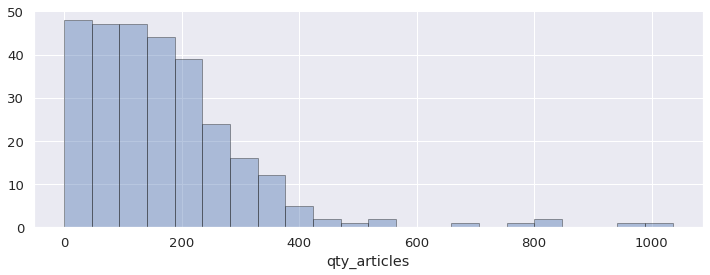

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_dist_qty['qty_articles'], hist_kws=dict(ec="k"), kde=False)

A few customers seems to have quite large quantities in their orders but the distribution is generally healthy. 

They could be weird behavior for the same customers but the Standard Deviation filters should minimize the risk. 

Analyzing those few outliers can be part of additional data preparation work that can help improve your model.

### Per value
This section shows that there are quite a few outliers 'outliers' that spend way more than others. We want to ignore them when creating the RFM values.

In [ ]:
%%bigquery df_dist_values --params $LTV_PARAMS --project $PROJECT_ID

SELECT value
FROM `ltv_ecommerce.20_aggred`

(-200.0, 3500.0)

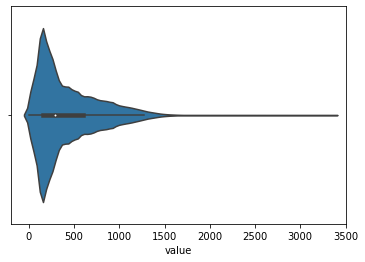

In [ ]:
axv = sns.violinplot(x=df_dist_values["value"])
axv.set_xlim(-200, 3500)

The distribution shows a few outliers that you could investigate to improve the base model that you create in this tutorial.

## Create inputs and targets for the ML model
The goal of this tutorial is to predict *How much each customer is going to spend in the next N days knowing their transactions history.*

Because all customers have different buying behavior over a specific period of time, this tutorial create multiple records per customer by:

1. Moving a threshold date by `WINDOW_STEP` over the dataset to create input and targets.
1. Aggregates input data per customer using transactions between `WINDOW_START` and `THRESHOLD_DATE` threshold date.
1. Aggregates the monetary value of the target transactions whose dates are between `THRESHOLD_DATE` and `THRESHOLD_DATE + LENGTH_FUTURE`.

Based on the size of your dataset and what you are trying to predict, you can update those values as needed in the *Set parameters for LTV* section.

This tutorial uses all historical data to predict the monetary value of its customers in the next 30 (`LENGTH_FUTURE`) days with a dataset that contains inputs/target value calculated every 30 days (`WINDOW_STEP`).

### Query

In [ ]:
%%bigquery --params $LTV_PARAMS --project $PROJECT_ID

-- Lenght are number of days
--
-- Date of the first order in the dataset.
DECLARE MIN_DATE DATE;                                          
-- Date of the final order in the dataset.
DECLARE MAX_DATE DATE;                                          
-- Date that separates inputs orders from target transactions.
DECLARE THRESHOLD_DATE DATE;                                    
-- How many days back for inputs transactions. 0 means from the start.
DECLARE WINDOW_LENGTH INT64 DEFAULT @WINDOW_LENGTH;
-- Date at which an input transactions window starts.
DECLARE WINDOW_START DATE;
-- How many days between thresholds.
DECLARE WINDOW_STEP INT64 DEFAULT @WINDOW_STEP;                 
-- How many days for the first window.
DECLARE WINDOW_STEP_INITIAL INT64 DEFAULT @WINDOW_STEP_INITIAL; 
-- Index of the window being run.
DECLARE STEP INT64 DEFAULT 1;                                   
-- How many days to predict for.
DECLARE LENGTH_FUTURE INT64 DEFAULT @LENGTH_FUTURE;                            

SET (MIN_DATE, MAX_DATE) = (
  SELECT AS STRUCT 
    MIN(order_day) AS min_days,
    MAX(order_day) AS max_days
  FROM
    `ltv_ecommerce.20_aggred`
);

SET THRESHOLD_DATE = MIN_DATE;

-- For more information about the features of this table,
-- see https://github.com/CamDavidsonPilon/lifetimes/blob/master/lifetimes/utils.py#L246
-- and https://cloud.google.com/solutions/machine-learning/clv-prediction-with-offline-training-train#aggregating_data
CREATE OR REPLACE TABLE ltv_ecommerce.30_featured
(
  -- dataset STRING,
  customer_id STRING,
  monetary FLOAT64,
  frequency INT64,
  recency INT64,
  T INT64,
  time_between FLOAT64,
  avg_basket_value FLOAT64,
  avg_basket_size FLOAT64,
  has_returns STRING,
  avg_time_to_return FLOAT64,
  num_returns INT64,
  -- threshold DATE,
  -- step INT64,
  target_monetary FLOAT64,
);

LOOP
  -- Can choose a longer original window in case 
  -- there were not many orders in the early days.
  IF STEP = 1 THEN
    SET THRESHOLD_DATE = DATE_ADD(THRESHOLD_DATE, INTERVAL WINDOW_STEP_INITIAL DAY); 
  ELSE
    SET THRESHOLD_DATE = DATE_ADD(THRESHOLD_DATE, INTERVAL WINDOW_STEP DAY);
  END IF;
  SET STEP = STEP + 1;

  IF THRESHOLD_DATE >= DATE_SUB(MAX_DATE, INTERVAL (WINDOW_STEP) DAY) THEN
    LEAVE;
  END IF;

  -- Takes all transactions before the threshold date unless you decide
  -- to use a different window lenght to test model performance.
  IF WINDOW_LENGTH != 0 THEN
    SET WINDOW_START = DATE_SUB(THRESHOLD_DATE, INTERVAL WINDOW_LENGTH DAY);
  ELSE
    SET WINDOW_START = MIN_DATE;
  END IF;

  INSERT ltv_ecommerce.30_featured
  SELECT
    -- CASE
    --   WHEN THRESHOLD_DATE <= DATE_SUB(MAX_DATE, INTERVAL LENGTH_FUTURE DAY) THEN 'UNASSIGNED'
    --   ELSE 'TEST'
    -- END AS dataset,
    CAST(tf.customer_id AS STRING),
    ROUND(tf.monetary_orders, 2) AS monetary,
    tf.cnt_orders AS frequency,
    tf.recency,
    tf.T,
    ROUND(tf.recency/cnt_orders, 2) AS time_between,
    ROUND(tf.avg_basket_value, 2) AS avg_basket_value,
    ROUND(tf.avg_basket_size, 2) AS avg_basket_size,
    has_returns,
    CEIL(avg_time_to_return) AS avg_time_to_return,
    num_returns,
    -- THRESHOLD_DATE AS threshold,
    -- STEP - 1 AS step,
    ROUND(tt.target_monetary, 2) AS target_monetary,
  FROM (
      -- This SELECT uses only data before THRESHOLD_DATE to make features.
      SELECT
        customer_id,
        SUM(value) AS monetary_orders,
        DATE_DIFF(MAX(order_day), MIN(order_day), DAY) AS recency,
        DATE_DIFF(THRESHOLD_DATE, MIN(order_day), DAY) AS T,
        COUNT(DISTINCT order_day) AS cnt_orders,
        AVG(qty_articles) avg_basket_size,
        AVG(value) avg_basket_value,
        CASE
          WHEN SUM(num_returns) > 0 THEN 'y'
          ELSE 'n'
        END AS has_returns,
        AVG(time_to_return) avg_time_to_return,
        THRESHOLD_DATE AS threshold,
        SUM(num_returns) num_returns,
      FROM
        `ltv_ecommerce.20_aggred`
      WHERE
        order_day <= THRESHOLD_DATE AND
        order_day >= WINDOW_START
      GROUP BY
        customer_id
    ) tf
  INNER JOIN (
    -- This SELECT uses all data after threshold as target.
    SELECT
      customer_id,
      SUM(value) target_monetary
    FROM
      `ltv_ecommerce.20_aggred`
    WHERE
      order_day <= DATE_ADD(THRESHOLD_DATE, INTERVAL LENGTH_FUTURE DAY)
      -- Overall value is similar to predicting only what's after threshold.
      -- and the prediction performs better. We can substract later.
      -- AND order_day > THRESHOLD_DATE
    GROUP BY
      customer_id) tt
  ON
    tf.customer_id = tt.customer_id;

END LOOP;

""


### Dataset

In [ ]:
%%bigquery --project $PROJECT_ID

-- Shows all data for a specific customer and some other random records.
SELECT * FROM `ltv_ecommerce.30_featured` WHERE customer_id = "10"
UNION ALL
(SELECT * FROM `ltv_ecommerce.30_featured` LIMIT 5)
ORDER BY customer_id, frequency, T

,customer_id,monetary,frequency,recency,T,time_between,avg_basket_value,avg_basket_size,has_returns,avg_time_to_return,num_returns,target_monetary
0,10,557.93,1,0,5,0.00,557.93,7.00,n,NaN,0,1907.18
1,10,1907.18,2,16,35,8.00,953.59,25.50,y,3.0,51,3126.09
2,10,3126.09,4,52,65,13.00,781.52,22.50,y,2.0,93,3227.99
3,10,3227.99,5,75,95,15.00,645.60,20.00,y,2.0,105,3227.99
4,10,3227.99,5,75,125,15.00,645.60,20.00,y,2.0,105,4216.18
5,10,4216.18,6,141,155,23.50,702.70,22.00,y,2.0,140,4216.18
6,10,4216.18,6,141,185,23.50,702.70,22.00,y,2.0,140,4354.60
7,10,4354.60,7,193,215,27.57,622.09,19.14,y,2.0,140,5215.47
8,10,5215.47,8,231,245,28.88,651.93,21.25,y,2.0,165,5694.20
9,11904,0.00,1,0,82,0.00,0.00,0.00,y,29.0,1,243.88


In [ ]:
%%bigquery df_featured --project $PROJECT_ID

ltv_ecommerce.30_featured

In [ ]:
df_featured.describe()

,monetary,frequency,recency,T,time_between,avg_basket_value,avg_basket_size,avg_time_to_return,num_returns,target_monetary
count,711486.000000,711486.000000,711486.000000,711486.000000,711486.000000,711486.000000,711486.000000,632923.000000,711486.000000,711486.000000
mean,1083.651997,2.340872,72.325732,138.014234,23.380073,475.360193,20.357123,2.488856,37.084156,1209.046128
std,948.881772,1.451241,80.694212,81.896254,25.485559,479.298791,18.767243,1.320465,33.045139,1003.381286
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,405.310000,1.000000,0.000000,71.000000,0.000000,243.880000,11.000000,2.000000,12.000000,485.780000
50%,838.355000,2.000000,45.000000,132.000000,18.000000,405.550000,16.670000,2.000000,29.000000,960.890000
75%,1493.560000,3.000000,127.000000,200.000000,39.500000,596.900000,24.750000,3.000000,52.000000,1670.230000
max,31088.880000,15.000000,330.000000,330.000000,164.500000,31088.880000,1036.000000,29.000000,351.000000,31088.880000


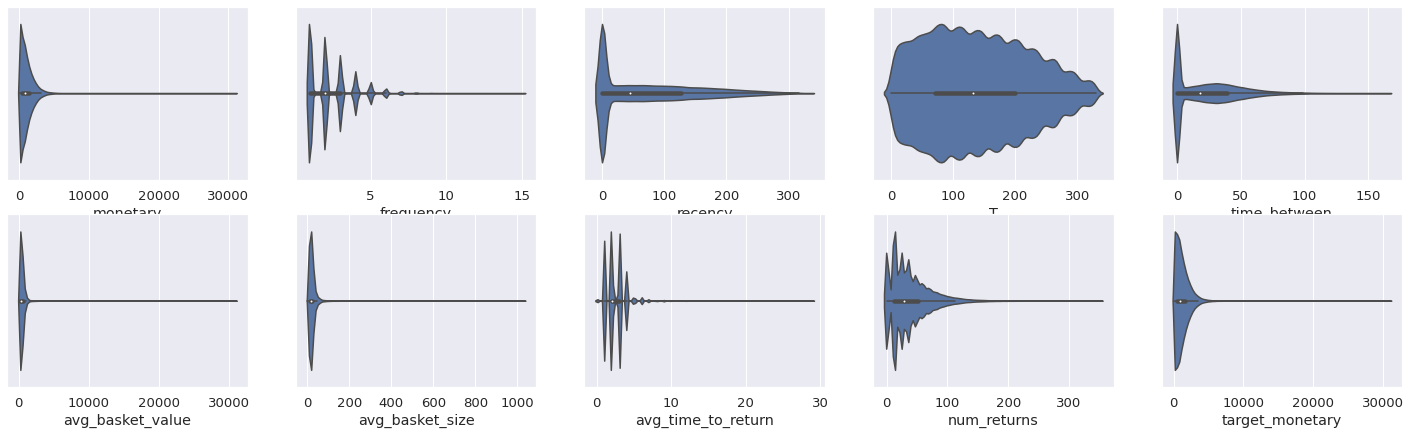

In [ ]:
# Display distribution for all columns that are numerical (but will still ignore the categorical ones like day of the week)
valid_column_names = [key for key in dict(df_featured.dtypes) if dict(df_featured.dtypes)[key] in ['float64', 'int64']]
NUM_COLS = 5
NUM_ROWS = math.ceil(int(len(valid_column_names)) / NUM_COLS)

fig, axs = plt.subplots(nrows=NUM_ROWS, ncols=NUM_COLS, figsize=(25, 7))

for idx, cname in enumerate(valid_column_names):
  x = int(idx/NUM_COLS)
  y = idx % NUM_COLS
  sns.violinplot(df_featured[cname], ax=axs[x, y], label=cname)


Seems like for most values, there is a long tail of records. This is something that might required additional feature preparation even if AutoML already provides some automatic engineering. You can investigate this if you want to improve the base model.

## Train the model
This tutorial uses an AutoML regressor to predict the continuous value of target_monetary.

With a non-AutoML model, you would generally need to:
1. Apply common ML patterns such as normalization or clipping.
1. Split data in two to three datasets for training, evaluating and testing.

AutoML lets you split your data:
- Manually using a column with a name for each split.
- Manually using a column that defines a time
- Automatically

This tutorial uses the latter option where AutoML automatically assigns each row to a split.

In [ ]:
# You can run this query using the magic cell but the cell would run for hours.
# Although stopping the cell would not stop the query, using the Python client
# also enables you to add a custom parameter for the model name.
suffix_now = datetime.now().strftime("%Y%m%d_%H%M%S")
train_model_jobid = f'train_model_{suffix_now}'

train_model_sql = f'''
CREATE OR REPLACE MODEL `ltv_ecommerce.model_tutorial_{suffix_now}`
       OPTIONS(MODEL_TYPE="AUTOML_REGRESSOR",
               INPUT_LABEL_COLS=["target_monetary"],
               OPTIMIZATION_OBJECTIVE="MINIMIZE_MAE")
AS SELECT 
  * EXCEPT(customer_id)
FROM 
  `ltv_ecommerce.30_featured`
'''

bq_client.query(train_model_sql, job_id=train_model_jobid)

This is an example of a model evaluation

![Model Evaluation](https://storage.googleapis.com/solutions-public-assets/analytics-componentized-patterns/ltv/model_evaluation.png)

## Predict LTV
Predicts LTV for all customers. It uses the overall monetary value for each customer to predict a future one.

In [ ]:
%%bigquery --params $LTV_PARAMS --project $PROJECT_ID

-- TODO(developer): 
-- 1. Update the model name to the one you want to use.
-- 2. Update the table where to output predictions.

-- How many days back for inputs transactions. 0 means from the start.
DECLARE WINDOW_LENGTH INT64 DEFAULT @WINDOW_LENGTH;
-- Date at which an input transactions window starts.
DECLARE WINDOW_START DATE;

-- Date of the first transaction in the dataset.
DECLARE MIN_DATE DATE;                                          
-- Date of the final transaction in the dataset.
DECLARE MAX_DATE DATE; 
-- Date from which you want to predict.
DECLARE PREDICT_FROM_DATE DATE;

SET (MIN_DATE, MAX_DATE) = (
  SELECT AS STRUCT 
    MIN(order_day) AS min_days,
    MAX(order_day) AS max_days
  FROM
    `ltv_ecommerce.20_aggred`
);

-- You can set any date here. In production, it is generally today.
SET PREDICT_FROM_DATE = MAX_DATE;

IF WINDOW_LENGTH != 0 THEN
  SET WINDOW_START = DATE_SUB(PREDICT_FROM_DATE, INTERVAL WINDOW_LENGTH DAY);
ELSE
  SET WINDOW_START = MIN_DATE;
END IF;

CREATE OR REPLACE TABLE `ltv_ecommerce.predictions_tutorial`
AS (
SELECT
  customer_id,
  monetary AS monetary_so_far,
  ROUND(predicted_target_monetary, 2) AS monetary_predicted,
  ROUND(predicted_target_monetary - monetary, 2) AS monetary_future
FROM
  ML.PREDICT(
    -- /!\ Set your model name here.
    MODEL ltv_ecommerce.model_tutorial_YYYYMMDD,
    (
      SELECT
        customer_id,
        ROUND(monetary_orders, 2) AS monetary,
        cnt_orders AS frequency,
        recency,
        T,
        ROUND(recency/cnt_orders, 2) AS time_between,
        ROUND(avg_basket_value, 2) AS avg_basket_value,
        ROUND(avg_basket_size, 2) AS avg_basket_size,
        has_returns,
        CEIL(avg_time_to_return) AS avg_time_to_return,
        num_returns
      FROM (
        SELECT
          customer_id,
          SUM(value) AS monetary_orders,
          DATE_DIFF(MAX(order_day), MIN(order_day), DAY) AS recency,
          DATE_DIFF(PREDICT_FROM_DATE, MIN(order_day), DAY) AS T,
          COUNT(DISTINCT order_day) AS cnt_orders,
          AVG(qty_articles) avg_basket_size,
          AVG(value) avg_basket_value,
          CASE
            WHEN SUM(num_returns) > 0 THEN 'y'
            ELSE 'n'
          END AS has_returns,
          AVG(time_to_return) avg_time_to_return,
          SUM(num_returns) num_returns,
        FROM
          `ltv_ecommerce.20_aggred`
        WHERE
          order_day <= PREDICT_FROM_DATE AND
          order_day >= WINDOW_START
        GROUP BY
          customer_id
      )
    )
  )
)

In [ ]:
%%bigquery df_predictions --project $PROJECT_ID

ltv_ecommerce.predictions_windowed

In [ ]:
df_predictions.describe()

,monetary_so_far,monetary_predicted,monetary_future
count,99070.000000,99070.000000,99070.000000
mean,1524.427797,1526.421037,1.993238
std,1158.682823,1159.478577,1.632896
min,0.000000,0.100000,-31.340000
25%,652.230000,653.422500,0.950000
50%,1279.300000,1281.170000,1.610000
75%,2131.797500,2134.117500,2.770000
max,31088.880000,31057.540000,24.630000


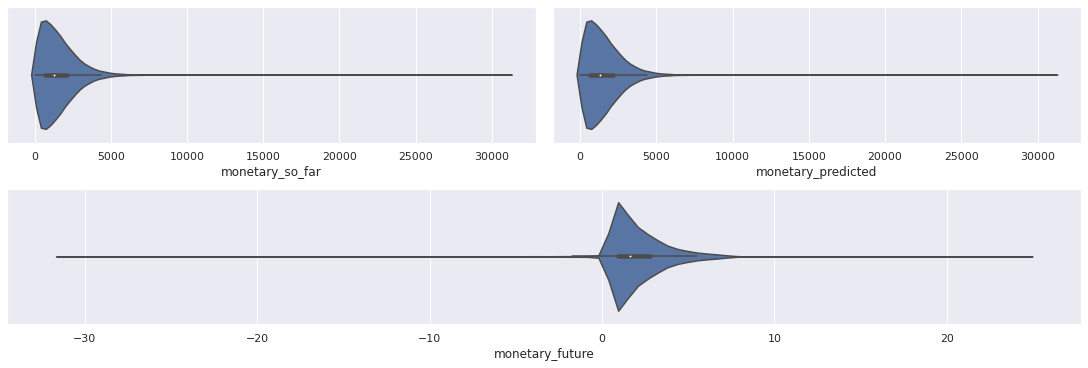

In [ ]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(constrained_layout=True, figsize=(15, 5))
gs = GridSpec(2, 2, figure=fig)

sns.set(font_scale = 1)
plt.tick_params(axis='x', labelsize=14)

ax0 = plt.subplot(gs.new_subplotspec((0, 0), colspan=1))
ax1 = plt.subplot(gs.new_subplotspec((0, 1), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((1, 0), colspan=2))

sns.violinplot(df_predictions['monetary_so_far'], ax=ax0, label='monetary_so_far')
sns.violinplot(df_predictions['monetary_predicted'], ax=ax1, label='monetary_predicted')
sns.violinplot(df_predictions['monetary_future'], ax=ax2, label='monetary_future')

The monetary distribution analysis shows small monetary amounts for the next month compare to the overall historical value. The difference is about 3 to 4 orders of magnitude.

One reason is that the model is trained to predict the value for the next month (LENGTH_FUTURE = 30). 

You can play around with that value to train and predict for the next quarter for example (LENGTH_FUTURE = 90)

## Activation
This part shows how to activate on [Google Ads][lookalike_adwords] using similar audience.

You can follow a similar process for [Facebook][lookalike_facebook] for example

[lookalike_adwords]: https://developers.google.com/adwords/api/docs/guides/remarketing#customer_match_with_email_address_address_or_user_id
[lookalike_facebook]: https://www.facebook.com/business/help/170456843145568?id=2469097953376494

### Extract top customers

This step extracts the top 20% customers with the highest **future** monetary value and join with a CRM table to get their email. 

The prediction used the overall monetary value but in this use case, we are looking at the most valuable in the future. You can modify the PERCENT_RANK to use another KPI.

In [6]:
%%bigquery df_top_ltv --params $LTV_PARAMS --project $PROJECT_ID

DECLARE TOP_LTV_RATIO FLOAT64 DEFAULT @TOP_LTV_RATIO;

SELECT
  p.customer_id,
  monetary_future,
  c.email AS email
FROM (
  SELECT
    customer_id,
    monetary_future,
    PERCENT_RANK() OVER (ORDER BY monetary_future DESC) AS percent_rank_monetary
  FROM
    `ltv_ecommerce.predictions_windowed` ) p
-- This creates fake emails. You need to join with your own CRM table.
INNER JOIN (
  SELECT
    customer_id,
    email
  FROM
    `ltv_ecommerce.00_crm` ) c
ON
  p.customer_id = CAST(c.customer_id AS STRING)
WHERE
  -- Decides the size of your list of emails. For similar-audience use cases 
  -- where you need to find a minimum of matching emails, 20% should provide
  -- enough potential emails.
  percent_rank_monetary <= TOP_LTV_RATIO
ORDER BY monetary_future DESC

In [7]:
df_top_ltv.head(5)

,customer_id,monetary_future,email
0,11494,24.63,rmuir8v9@admin-example.ch
1,34304,19.11,ltomasuttiqgv@yellowpages-example.com
2,87023,16.41,rruhben1v5a@sakura.ne-example.jp
3,38601,15.93,dchelamts8@va-example.gov
4,42317,15.26,wwaudwng@dagondesign-example.com


       monetary_future
count     19880.000000
mean          4.451095
std           1.163329
min           3.100000
25%           3.520000
50%           4.130000
75%           5.120000
max          24.630000


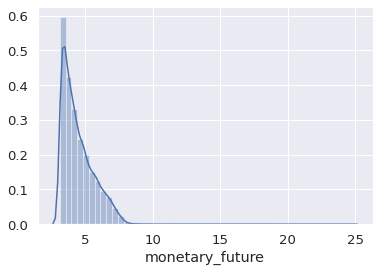

In [ ]:
# Shows distribution of the predicted monetary value for the top LTV customers.
print(df_top_ltv.describe())

fig, axs = plt.subplots()
sns.set(font_scale = 1.2)
sns.distplot(df_top_ltv['monetary_future'])

### Setup Adwords client
Creates the configuration YAML file for the Google Ads client. You need to:
1. Create Client ID and Secret using the Cloud Console
2. Follow [these steps](https://developers.google.com/google-ads/api/docs/client-libs/python/oauth-installed)

In [ ]:
# Sets your variables.
if 'google.colab' in sys.modules:
  from google.colab import files

ADWORDS_FILE = "/tmp/adwords.yaml"

DEVELOPER_TOKEN = "[YOUR_DEVELOPER_TOKEN]"
OAUTH_2_CLIENT_ID = "[YOUR_OAUTH_2_CLIENT_ID]"
CLIENT_SECRET = "[YOUR_CLIENT_SECRET]"
REFRESH_TOKEN = "[YOUR_REFRESH_TOKEN]"

In [ ]:
# Creates a local YAML file
adwords_content = f"""
# AdWordsClient configurations
adwords:
  #############################################################################
  # Required Fields                                                           #
  #############################################################################
  developer_token: {DEVELOPER_TOKEN}
  #############################################################################
  # Optional Fields                                                           #
  #############################################################################
  # client_customer_id: INSERT_CLIENT_CUSTOMER_ID_HERE
  # user_agent: INSERT_USER_AGENT_HERE
  # partial_failure: True
  # validate_only: True
  #############################################################################
  # OAuth2 Configuration                                                      #
  # Below you may provide credentials for either the installed application or #
  # service account flows. Remove or comment the lines for the flow you're    #
  # not using.                                                                #
  #############################################################################
  # The following values configure the client for the installed application
  # flow.
  client_id: {OAUTH_2_CLIENT_ID}
  client_secret: {CLIENT_SECRET}
  refresh_token: {REFRESH_TOKEN}
  # The following values configure the client for the service account flow.
  # path_to_private_key_file: INSERT_PATH_TO_JSON_KEY_FILE_HERE
  # delegated_account: INSERT_DOMAIN_WIDE_DELEGATION_ACCOUNT
  #############################################################################
  # ReportDownloader Headers                                                  #
  # Below you may specify boolean values for optional headers that will be    #
  # applied to all requests made by the ReportDownloader utility by default.  #
  #############################################################################
  # report_downloader_headers:
    # skip_report_header: False
    # skip_column_header: False
    # skip_report_summary: False
    # use_raw_enum_values: False


# AdManagerClient configurations
ad_manager:
  #############################################################################
  # Required Fields                                                           #
  #############################################################################
  application_name: INSERT_APPLICATION_NAME_HERE
  #############################################################################
  # Optional Fields                                                           #
  #############################################################################
  # The network_code is required for all services except NetworkService:
  # network_code: INSERT_NETWORK_CODE_HERE
  # delegated_account: INSERT_DOMAIN_WIDE_DELEGATION_ACCOUNT
  #############################################################################
  # OAuth2 Configuration                                                      #
  # Below you may provide credentials for either the installed application or #
  # service account (recommended) flows. Remove or comment the lines for the  #
  # flow you're not using.                                                    #
  #############################################################################
  # The following values configure the client for the service account flow.
  path_to_private_key_file: INSERT_PATH_TO_JSON_KEY_FILE_HERE
  # delegated_account: INSERT_DOMAIN_WIDE_DELEGATION_ACCOUNT
  # The following values configure the client for the installed application
  # flow.
  # client_id: INSERT_OAUTH_2_CLIENT_ID_HERE
  # client_secret: INSERT_CLIENT_SECRET_HERE
  # refresh_token: INSERT_REFRESH_TOKEN_HERE


# Common configurations:
###############################################################################
# Compression (optional)                                                      #
# Below you may specify whether to accept and automatically decompress gzip   #
# encoded SOAP requests. By default, gzip compression is not enabled.         #
###############################################################################
# enable_compression: False
###############################################################################
# Logging configuration (optional)                                            #
# Below you may specify the logging configuration. This will be provided as   #
# an input to logging.config.dictConfig.                                      #
###############################################################################
# logging:
  # version: 1
  # disable_existing_loggers: False
  # formatters:
    # default_fmt:
      # format: ext://googleads.util.LOGGER_FORMAT
  # handlers:
    # default_handler:
      # class: logging.StreamHandler
      # formatter: default_fmt
      # level: INFO
  # loggers:
    # Configure root logger
    # "":
      # handlers: [default_handler]
      # level: INFO
###############################################################################
# Proxy configurations (optional)                                             #
# Below you may specify an HTTP or HTTPS Proxy to be used when making API     #
# requests. Note: You must specify the scheme used for the proxy endpoint.    #
#                                                                             #
# For additional information on configuring these values, see:                #
# http://docs.python-requests.org/en/master/user/advanced/#proxies            #
###############################################################################
# proxy_config:
  # http: INSERT_HTTP_PROXY_URI_HERE
  # https: INSERT_HTTPS_PROXY_URI_HERE
  # If specified, the given cafile will only be used if certificate validation
  # is not disabled.
  # cafile: INSERT_PATH_HERE
  # disable_certificate_validation: False
################################################################################
# Utilities Included (optional)                                                #
# Below you may specify whether the library will include utilities used in the #
# user agent. By default, the library will include utilities used in the user  #
# agent.                                                                       #
################################################################################
# include_utilities_in_user_agent: True
################################################################################
# Custom HTTP headers (optional)                                               #
# Specify one or more custom headers to pass along with all requests to        #
# the API.                                                                     #
################################################################################
# custom_http_headers:
#   X-My-Header: 'content'
"""

In [ ]:
with open(ADWORDS_FILE, "w") as adwords_file:
    print(adwords_content, file=adwords_file)

In [ ]:
# Google Ads client
# adwords_client = adwords.AdWordsClient.LoadFromStorage(ADWORDS_FILE)

### Create an AdWords user list
Using emails of the top LTV customers, you create an AdWords list. If more than 5000 of the users are matched with AdWords email, a similar audience list will be created.

> Note that this guide uses fake emails so running these steps is not going to work but you can leverage this code with emails coming from your CRM.

In [ ]:
ltv_emails = list(set(df_top_ltv['email']))

In [ ]:
# https://developers.google.com/adwords/api/docs/samples/python/remarketing#create-and-populate-a-user-list
# https://github.com/googleads/googleads-python-lib/blob/7c41584c65759b6860572a13bde65d7395c5b2d8/examples/adwords/v201809/remarketing/add_crm_based_user_list.py

# """Adds a user list and populates it with hashed email addresses.

# Note: It may take several hours for the list to be populated with members. Email
# addresses must be associated with a Google account. For privacy purposes, the
# user list size will show as zero until the list has at least 1000 members. After
# that, the size will be rounded to the two most significant digits.
# """
# def normalize_and_SHA256(s):
#   """Normalizes (lowercase, remove whitespace) and hashes a string with SHA-256.

#   Args:
#     s: The string to perform this operation on.

#   Returns:
#     A normalized and SHA-256 hashed string.
#   """
#   return hashlib.sha256(s.strip().lower()).hexdigest()
  
# def create_user_list(client):
#   # Initialize appropriate services.
#   user_list_service = client.GetService('AdwordsUserListService', 'v201809')

#   user_list = {
#       'xsi_type': 'CrmBasedUserList',
#       'name': f'Customer relationship management list #{uuid.uuid4()}',
#       'description': 'A list of customers that originated from email addresses',
#       # CRM-based user lists can use a membershipLifeSpan of 10000 to indicate
#       # unlimited; otherwise normal values apply.
#       'membershipLifeSpan': 30,
#       'uploadKeyType': 'CONTACT_INFO'
#   }

#   # Create an operation to add the user list.
#   operations = [{
#       'operator': 'ADD',
#       'operand': user_list
#   }]

#   result = user_list_service.mutate(operations)
#   user_list_id = result['value'][0]['id']

#   emails = ltv_emails
#   members = [{'hashedEmail': normalize_and_SHA256(email)} for email in emails]

#   mutate_members_operation = {
#       'operand': {
#           'userListId': user_list_id,
#           'membersList': members
#       },
#       'operator': 'ADD'
#   }

#   response = user_list_service.mutateMembers([mutate_members_operation])

#   if 'userLists' in response:
#     for user_list in response['userLists']:
#       print('User list with name "%s" and ID "%d" was added.'
#             % (user_list['name'], user_list['id']))

# create_user_list(adwords_client)

## Thoughts
As mentioned a few time, the goal of this tutorial is not to provide a state of the art model for predicting LTV but show a possible approach to create a base model for predicting future monetary value of your customers.

If you decided to investigate more the approach, you could:
- Do additional data engineering or find additional example when you see outliers.
- Try a different approach to create inputs. For example, you could:
  - Use a ratio of transactions as *input transactions* and the rest as *target transactions*. An earlier version of this tutorial tried that but the current method led to better results for the problem at hand (predict value in the next X days).
  - Customize the time range for input transactions. This tutorial uses all orders that happened before a threshold but you could image to use 6 months before to predict one month after.
  - The data preparation creates several examples from a unique customer by using multiple threshold dates. The model can link those example with their original customer. A more advanced approach could try to treat those example as timeseries examples and use how the customer behavior evolve over time. Model might perform better...or not. As you noticed, the `T` value kind of contains that information already across examples that might seem random to the model. Let us know if you decide to try and find some great results.
- When comparing models, make sure that you keep a unique test set to fairly compare the model's performance.
- This tutorial prepares the data knowing that you want to predict the orders for the next 30 days. If you want a model to predict for the next quarter, you need to update `LENGTH_FUTURE` and prepare a new training dataset.
- The original dataset uses a limited number of fields. If you have other dimensions such as product categories, regions or demographics, try to create additional inputs for your model.

# Cleaning up

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.